# Random Forest Model

## Initializing

In [1]:
import pandas as pd
import numpy as np

In [2]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem.snowball import EnglishStemmer, FrenchStemmer
from sklearn.feature_extraction._stop_words import ENGLISH_STOP_WORDS

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.utils import resample

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix

pd.set_option("display.max_colwidth", 100)
pd.set_option("display.max_rows", 100)

from matplotlib import pyplot as plt

In [3]:
#Raw dataset import
df= pd.read_csv("dataset.csv", sep=';')

In [4]:
print(df.shape)
print(list(df.columns))

(156, 72)
['ID', 'geoCountryName', 'geoLocationName', 'summary', 'industryName', 'headline', 'languages', 'publications', 'certifications', 'volunteer', 'honors', 'projects', 'exp1_locationName', 'exp1_companyName', 'exp1_description', 'exp1_title', 'exp1_startDate_month', 'exp1_startDate_year', 'exp1_industry', 'exp1_company_empl_low', 'exp2_locationName', 'exp2_companyName', 'exp2_description', 'exp2_title', 'exp2_startDate_month', 'exp2_startDate_year', 'exp2_endDate_month', 'exp2_endDate_year', 'exp2_industry', 'exp2_company_empl_low', 'exp3_locationName', 'exp3_companyName', 'exp3_title', 'exp3_description', 'exp3_startDate_month', 'exp3_startDate_year', 'exp3_endDate_month', 'exp3_endDate_year', 'exp3_industry', 'exp3_company_empl_low', 'exp4_locationName', 'exp4_companyName', 'exp4_description', 'exp4_title', 'exp4_startDate_month', 'exp4_startDate_year', 'exp4_endDate_month', 'exp4_endDate_year', 'exp4_industry', 'exp4_company_empl_low', 'exp5_locationName', 'exp5_companyName',

In [5]:
df.exp1_industry.value_counts()

Computer Software                      19
Information Technology and Services    17
Civic Social Organization              13
Government Administration              12
Management Consulting                   8
Higher Education                        8
Research                                7
International Affairs                   4
Nonprofit Organization Management       4
Internet                                3
Leisure Travel Tourism                  3
Public Relations and Communications     3
Banking                                 3
Online Media                            2
Think Tanks                             2
Renewables Environment                  2
Venture Capital Private Equity          2
Performing Arts                         2
Marketing and Advertising               2
Pharmaceuticals                         1
Farming                                 1
Design                                  1
Fine Art                                1
Insurance                         

In [6]:
len(df.exp1_industry.unique())

44

In [7]:
print(len(list(df.exp1_companyName.unique())))
print(list(df.exp1_companyName.unique()))

128
['bluenove', 'jolicode', 'cap collectif', 'change.org', 'fluicity', 'adie', 'civocracy', 'VOXE', 'abcdeep', 'sdui', 'leto', 'make.org', 'klarna', 'open source politics', 'sell - syndicat des éditeurs de logiciels de loisirs', 'freelance', 'ad education', 'nestlé france', 'analog sport', 'la cour des contes', 'malt', 'decidim', 'sloop', 'impact hub berlin', 'the one campaign', 'billy', 'institut des politiques publiques', 'egis', 'roch ventures', 'multitudes foundation', "ville d'alfortville", 'afd', 'trikoï conseil', 'google', 'sciences po ofce', 'orchestre national de jazz', 'hippocrate développement', 'sobi - swedish orphan biovitrum ab (publ)', 'capgemini invent', 'impact tank', 'ville de lyon', 'datagora', 'grandvision france', 'cour des comptes', "l'institut paris region", 'umi', 'udaf 71', 'avolta', 'university of paris i: panthéon-sorbonne', 'ville de cachan', 'edf', 'combo (ex-snapshift)', 'cerba healthcare', 'accenta.ai', 'sicoval', 'haute autorité de santé', "journaliste 

## Preparing the dataframe

In [8]:
# our "y" here is the exp1_industry 
# it could be the companies but there are a lot of them (128)
# next we are going to drop everything else related to the 1st (last) experience
# ['exp1_locationName', 'exp1_companyName',
#       'exp1_description', 'exp1_title', 'exp1_startDate_month',
#       'exp1_startDate_year', 'exp1_industry', 'exp1_company_empl_low']
# as well as the ID 

In [9]:
df.set_index(['exp1_industry'], drop=True, inplace=True)

In [10]:
df.drop(columns=["ID", 'exp1_locationName', 'exp1_companyName',
       'exp1_description', 'exp1_title', 'exp1_startDate_month',
       'exp1_startDate_year', 'exp1_company_empl_low'], inplace=True)

In [11]:
list_df_columns= list(df.columns)
print(list_df_columns)

['geoCountryName', 'geoLocationName', 'summary', 'industryName', 'headline', 'languages', 'publications', 'certifications', 'volunteer', 'honors', 'projects', 'exp2_locationName', 'exp2_companyName', 'exp2_description', 'exp2_title', 'exp2_startDate_month', 'exp2_startDate_year', 'exp2_endDate_month', 'exp2_endDate_year', 'exp2_industry', 'exp2_company_empl_low', 'exp3_locationName', 'exp3_companyName', 'exp3_title', 'exp3_description', 'exp3_startDate_month', 'exp3_startDate_year', 'exp3_endDate_month', 'exp3_endDate_year', 'exp3_industry', 'exp3_company_empl_low', 'exp4_locationName', 'exp4_companyName', 'exp4_description', 'exp4_title', 'exp4_startDate_month', 'exp4_startDate_year', 'exp4_endDate_month', 'exp4_endDate_year', 'exp4_industry', 'exp4_company_empl_low', 'exp5_locationName', 'exp5_companyName', 'exp5_description', 'exp5_title', 'exp5_startDate_month', 'exp5_startDate_year', 'exp5_endDate_month', 'exp5_endDate_year', 'exp5_industry', 'exp5_company_empl_low', 'ed1_degreeNa

In [12]:
df=df.applymap(str)

In [13]:
df["text"] = df[list_df_columns].apply(lambda x: " ".join(x), axis =1)
df.reset_index(inplace=True)
mod_df=df[["exp1_industry", "text"]]
mod_df.head(2)

,exp1_industry,text
0,Management Consulting,France Paris Metropolitan Region Antoine croit à l’intelligence de tous et à la responsabilité d...
1,NaN,"France Paris Metropolitan Region IT Consultant, Technical Expert, Lead developer, I have an exte..."


In [14]:
# mod_df.isna().sum()
# keep this dataframe because it could be useful to test the model later
exp1_industry_nan= mod_df.loc[mod_df["exp1_industry"].isna()]
mod_df= mod_df.loc[mod_df["exp1_industry"].notna()]

In [15]:
# String with special characters 
special_string="sPe@#$ci8<\n7al*& m_ot.h[r f{uc'6r"
print("String before conversion: ",special_string)
# Create a list with normal characters using the isalnum() method
# use the join() function to convert the list to string
normal_string="".join(ch for ch in special_string if ch.isalnum() or ch==' ')
# print the normal string 
print("string after conversion:",normal_string)

String before conversion:  sPe@#$ci8<
7al*& m_ot.h[r f{uc'6r
string after conversion: sPeci87al mothr fuc6r


In [16]:
def clean_text_col(x):
    x=str(x)
    x= "".join(ch for ch in x if ch.isalnum() or ch==' ')
    x= x.lower()
    return x

In [17]:
mod_df.columns

Index(['exp1_industry', 'text'], dtype='object')

In [18]:
mod_df["text"] = mod_df['text'].apply(clean_text_col)

In [19]:
mod_df.head(2)

,exp1_industry,text
0,Management Consulting,france paris metropolitan region antoine croit à lintelligence de tous et à la responsabilité de...
2,Computer Software,france paris metropolitan region nan it services and it consulting directrice des opérations che...


In [20]:
top_industries= pd.DataFrame(mod_df.exp1_industry.value_counts())

In [21]:
top_industries.head(10)

,exp1_industry
Computer Software,19
Information Technology and Services,17
Civic Social Organization,13
Government Administration,12
Management Consulting,8
Higher Education,8
Research,7
International Affairs,4
Nonprofit Organization Management,4
Internet,3


In [22]:
factor = pd.factorize(mod_df['exp1_industry'])
mod_df.exp1_industry = factor[0]
definitions = factor[1]
print(mod_df.exp1_industry.head())
print(definitions)


0    0
2    1
3    2
4    3
5    4
Name: exp1_industry, dtype: int64
Index(['Management Consulting', 'Computer Software', 'Internet',
       'Information Technology and Services', 'Civic Social Organization',
       'Higher Education', 'Performing Arts', 'Marketing and Advertising',
       'Research', 'Civil Engineering', 'Venture Capital Private Equity',
       'Nonprofit Organization Management', 'Government Relations', 'Banking',
       'Education Management', 'Pharmaceuticals', 'Government Administration',
       'Information Services', 'Retail', 'Market Research',
       'Investment Banking', 'Renewables Environment', 'Hospital Health Care',
       'Chemicals', 'Human Resources', 'Public Relations and Communications',
       'International Affairs', 'Real Estate', 'Environmental Services',
       'Think Tanks', 'Farming', 'Architecture Planning',
       'Leisure Travel Tourism', 'Online Media', 'Computer Network Security',
       'Professional Training Coaching', 'Security and Inv

In [23]:
mod_df.head()

,exp1_industry,text
0,0,france paris metropolitan region antoine croit à lintelligence de tous et à la responsabilité de...
2,1,france paris metropolitan region nan it services and it consulting directrice des opérations che...
3,2,france paris metropolitan region people power civic and social organizations regional director f...
4,3,france paris metropolitan region 16 years of experience driving change in the tech media indust...
5,4,france paris metropolitan region nan nonprofit organizations directrice générale adjointe chez a...


## Setting X, y, test & train sets and vectorize

In [24]:
X= mod_df["text"]
y= mod_df["exp1_industry"]

In [25]:
texts_train, texts_test, Y_train, Y_test = train_test_split(X, y, test_size=0.15,
                                                            random_state=432)

In [26]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(texts_train)
X_test = vectorizer.transform(texts_test)

## Random Forest Classifier 1st try

In [27]:
# explain choice of model 
# classifier + categorical + approach 
# XGBoost would be cool for binary classification 

In [28]:
model_rf = RandomForestClassifier(random_state=42)

In [29]:
model_rf.fit(X_train, Y_train)

RandomForestClassifier(random_state=42)

In [30]:
y_pred = model_rf.predict(X_test)

In [31]:
accuracy_score(Y_test, y_pred)

0.5714285714285714

In [32]:
# Making the Confusion Matrix
# Note it concentrates the predictions (not all industries are used)
pd.crosstab(Y_test, y_pred, rownames=['Industry'], colnames=['Predicted Industry'])


Predicted Industry,0,1,3,4,6,16
Industry,,,,,,
0,2,0,0,0,0,0
1,0,2,0,0,0,0
3,0,1,3,0,0,0
4,0,0,0,4,0,0
5,0,0,1,0,0,0
8,0,1,0,0,0,0
16,0,0,0,0,0,1
17,0,0,1,0,0,0
19,0,1,0,0,0,0


In [33]:
accuracies_train = []
accuracies_test = []
params_grid = list(range(1, 30))

for param_value in params_grid:
    model = RandomForestClassifier(max_depth=param_value, random_state=98)
    model.fit(X_train, Y_train)
    Y_train_pred = model.predict(X_train)
    Y_val_pred = model.predict(X_test)
    accuracies_train.append(np.mean(Y_train_pred == Y_train))
    accuracies_test.append(np.mean(Y_val_pred == Y_test))

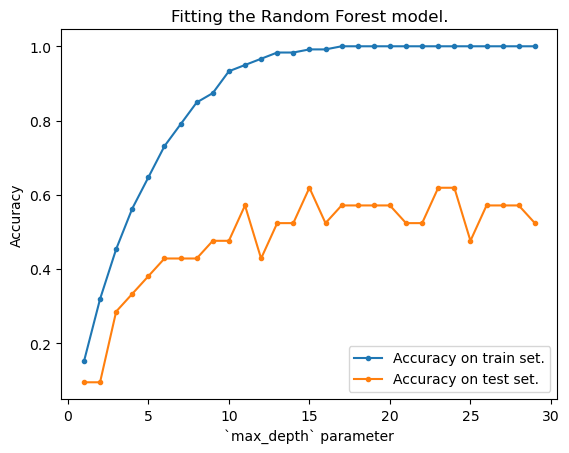

In [34]:
plt.plot(params_grid, accuracies_train, marker=".", label="Accuracy on train set.")
plt.plot(params_grid, accuracies_test, marker=".", label="Accuracy on test set.");
plt.title('Fitting the Random Forest model.')
plt.xlabel('`max_depth` parameter')
plt.ylabel('Accuracy')
plt.legend();

In [35]:
#Checking the results

In [36]:
#Reverse factorize (converting y_pred from 0s,1s and 2s to industries)
reversefactor = dict(zip(range(44),definitions))
Y_test = np.vectorize(reversefactor.get)(Y_test)
y_pred = np.vectorize(reversefactor.get)(y_pred)
# Check the industries that are used)
pd.crosstab(Y_test, y_pred, rownames=['Industry'], colnames=['Predicted Industry'])


Predicted Industry,Civic Social Organization,Computer Software,Government Administration,Information Technology and Services,Management Consulting,Performing Arts
Industry,,,,,,
Architecture Planning,0,0,0,1,0,0
Civic Social Organization,4,0,0,0,0,0
Computer Software,0,2,0,0,0,0
Government Administration,0,0,1,0,0,0
Higher Education,0,0,0,1,0,0
Information Services,0,0,0,1,0,0
Information Technology and Services,0,1,0,3,0,0
Investment Banking,0,0,0,1,0,0
Leisure Travel Tourism,0,0,0,0,0,1


In [37]:
top_industries.head(10)

,exp1_industry
Computer Software,19
Information Technology and Services,17
Civic Social Organization,13
Government Administration,12
Management Consulting,8
Higher Education,8
Research,7
International Affairs,4
Nonprofit Organization Management,4
Internet,3


Model tweaking with Gridsearch & parameters for the vectorizers: 
* Count : https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
* TDIF : https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
* Random Forest parameters: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

## RFC but dealing with imbalance. 

In [38]:
# Note : can't use the SMOTE model because not enough people per class
#sm = SMOTE(random_state=100,k_neighbors=5)
#X_train_SMOTE,y_train_SMOTE = sm.fit_resample(X_train,Y_train)

In [39]:
X= mod_df["text"]
y= mod_df["exp1_industry"]
texts_train, texts_test, Y_train, Y_test = train_test_split(X, y, test_size=0.15,
                                                            random_state=432)

In [40]:
train = pd.concat([texts_train, Y_train],axis=1)
train.head(2)

,text,exp1_industry
56,france nan nan business consulting and services consultante senior chez capgemini invent name en...,0
127,france paris metropolitan region nan computer and network security anticipation stratégique str...,34


In [41]:
print(len(train.exp1_industry.unique()))
print(len(train))
#train.exp1_industry.value_counts()

39
119


In [42]:
unique_ind = train.text.unique()
ind_dict = {elem : pd.DataFrame() for elem in unique_ind}
for key in ind_dict.keys():
    ind_dict[key] = train[:][train.text == key]

In [43]:
#for key, value in ind_dict.items():
#    print(value)

In [44]:
for key, value in ind_dict.items():
        if len(value)<=16:
                ind_dict[key] = resample(value, 
                                replace=True,
                                n_samples = 17,
                                random_state=0)

In [45]:
len(ind_dict)

119

In [46]:
ind_dict.values()

dict_values([                                                                                                   text  \
56  france nan nan business consulting and services consultante senior chez capgemini invent name en...   
56  france nan nan business consulting and services consultante senior chez capgemini invent name en...   
56  france nan nan business consulting and services consultante senior chez capgemini invent name en...   
56  france nan nan business consulting and services consultante senior chez capgemini invent name en...   
56  france nan nan business consulting and services consultante senior chez capgemini invent name en...   
56  france nan nan business consulting and services consultante senior chez capgemini invent name en...   
56  france nan nan business consulting and services consultante senior chez capgemini invent name en...   
56  france nan nan business consulting and services consultante senior chez capgemini invent name en...   
56  france nan nan busin

In [47]:
#ind_dict[list(ind_dict.keys())[1]]

In [48]:
newtrain=ind_dict[list(ind_dict.keys())[0]]
for i in range(1,len(ind_dict.keys())):
    newtrain= pd.concat([newtrain, ind_dict[list(ind_dict.keys())[i]]])

In [49]:
print(list(newtrain.exp1_industry.value_counts()))

[289, 221, 187, 153, 119, 102, 102, 68, 68, 51, 51, 51, 34, 34, 34, 34, 34, 34, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17, 17]


In [50]:
newtrain.columns

Index(['text', 'exp1_industry'], dtype='object')

In [51]:
y_train_resampled = newtrain['exp1_industry'].copy()
X_train_resampled = newtrain['text'].copy()

In [52]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train_resampled)
X_test = vectorizer.transform(texts_test)

In [53]:
model_rf = RandomForestClassifier(class_weight='balanced_subsample', random_state=86)
model_rf.fit(X_train, y_train_resampled)

RandomForestClassifier(class_weight='balanced_subsample', random_state=86)

In [54]:
y_pred = model_rf.predict(X_test)
accuracy_score(Y_test, y_pred)

0.6666666666666666

In [55]:
# Now that we have several (although identical) individuals per class
# we can calculate the cross validation score
cv_results = cross_val_score(model_rf, X_train, y_train_resampled, cv=5, scoring='accuracy')
cv_results

array([0.95802469, 1.        , 1.        , 1.        , 0.91584158])

## Max_depth and n_estimators parameter for RFC

### Max_depth

In [56]:
# Parameter testing for this model 
accuracies_train = []
accuracies_test = []
params_grid = list(range(1, 30))

for param_value in params_grid:
    model = RandomForestClassifier(max_depth=param_value, random_state=98)
    model.fit(X_train, y_train_resampled)
    Y_train_pred = model.predict(X_train)
    Y_val_pred = model.predict(X_test)
    accuracies_train.append(np.mean(Y_train_pred == y_train_resampled))
    accuracies_test.append(np.mean(Y_val_pred == Y_test))

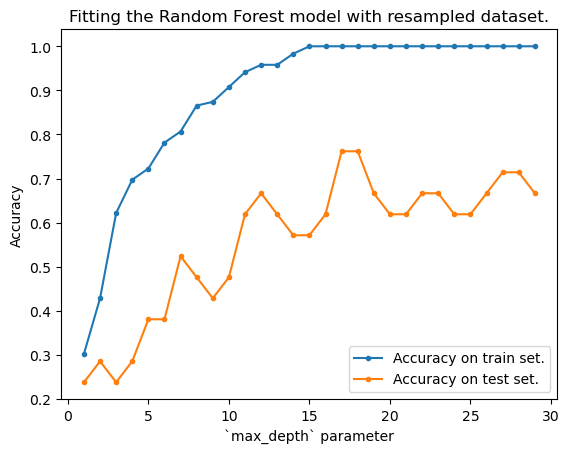

In [57]:
plt.plot(params_grid, accuracies_train, marker=".", label="Accuracy on train set.")
plt.plot(params_grid, accuracies_test, marker=".", label="Accuracy on test set.");
plt.title('Fitting the Random Forest model with resampled dataset.')
plt.xlabel('`max_depth` parameter')
plt.ylabel('Accuracy')
plt.legend();

In [58]:
model_rf = RandomForestClassifier(class_weight='balanced_subsample', random_state=86)

In [59]:
grid_search_cv = GridSearchCV(model_rf, {'max_depth': [15, 16, 17, 18, 19, 20]}, cv=3, scoring='accuracy')
grid_search_cv.fit(X_train, y_train_resampled)

GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                              random_state=86),
             param_grid={'max_depth': [15, 16, 17, 18, 19, 20]},
             scoring='accuracy')

In [60]:
grid_search_cv.best_score_

0.8571220280616917

In [61]:
grid_search_cv.best_params_

{'max_depth': 20}

In [62]:
# grid_search_cv.cv_results_

In [63]:
accuracies_train = []
accuracies_test = []
params_grid = [10, 20, 30, 50, 75, 100]

for param_value in params_grid:
    model = RandomForestClassifier(n_estimators=param_value, random_state=98)
    model.fit(X_train, y_train_resampled)
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)
    accuracies_train.append(np.mean(Y_train_pred == y_train_resampled))
    accuracies_test.append(np.mean(Y_test_pred == Y_test))

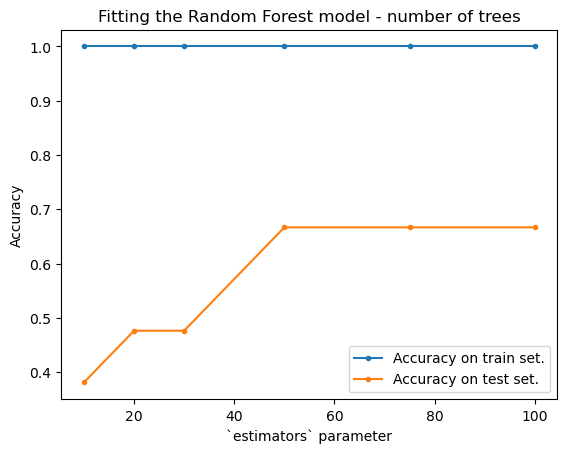

In [64]:
plt.plot(params_grid, accuracies_train, marker=".", label="Accuracy on train set.")
plt.plot(params_grid, accuracies_test, marker=".", label="Accuracy on test set.");
plt.title('Fitting the Random Forest model - number of trees')
plt.xlabel('`estimators` parameter')
plt.ylabel('Accuracy')
plt.legend();

# Final model with raw text

In [65]:
X= mod_df["text"]
y= mod_df["exp1_industry"]
texts_train, texts_test, Y_train, Y_test = train_test_split(X, y, test_size=0.15,
                                                            random_state=432)

In [66]:
train = pd.concat([texts_train, Y_train],axis=1)
print(len(train.exp1_industry.unique()))
print(len(train))
#train.exp1_industry.value_counts()

39
119


In [67]:
unique_ind = train.text.unique()
ind_dict = {elem : pd.DataFrame() for elem in unique_ind}
for key in ind_dict.keys():
    ind_dict[key] = train[:][train.text == key]

for key, value in ind_dict.items():
        if len(value)<=16:
                ind_dict[key] = resample(value, 
                                replace=True,
                                n_samples = 17,
                                random_state=0)

len(ind_dict)

119

In [68]:
#ind_dict[list(ind_dict.keys())[1]]

In [69]:
newtrain=ind_dict[list(ind_dict.keys())[0]]
for i in range(1,len(ind_dict.keys())):
    newtrain= pd.concat([newtrain, ind_dict[list(ind_dict.keys())[i]]])

y_train_resampled = newtrain['exp1_industry'].copy()
X_train_resampled = newtrain['text'].copy()

In [70]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train_resampled)
X_test = vectorizer.transform(texts_test)

In [71]:
model_rf = RandomForestClassifier(n_estimators= 50, max_depth= 17, random_state= 98)
model_rf.fit(X_train, y_train_resampled)

RandomForestClassifier(max_depth=17, n_estimators=50, random_state=98)

In [72]:
y_pred = model_rf.predict(X_test)
accuracy_score(Y_test, y_pred)

0.6190476190476191

In [73]:
cv_results = cross_val_score(model_rf, X_train, y_train_resampled, cv=5, scoring='accuracy')
cv_results

array([0.87407407, 0.91604938, 1.        , 1.        , 0.91584158])

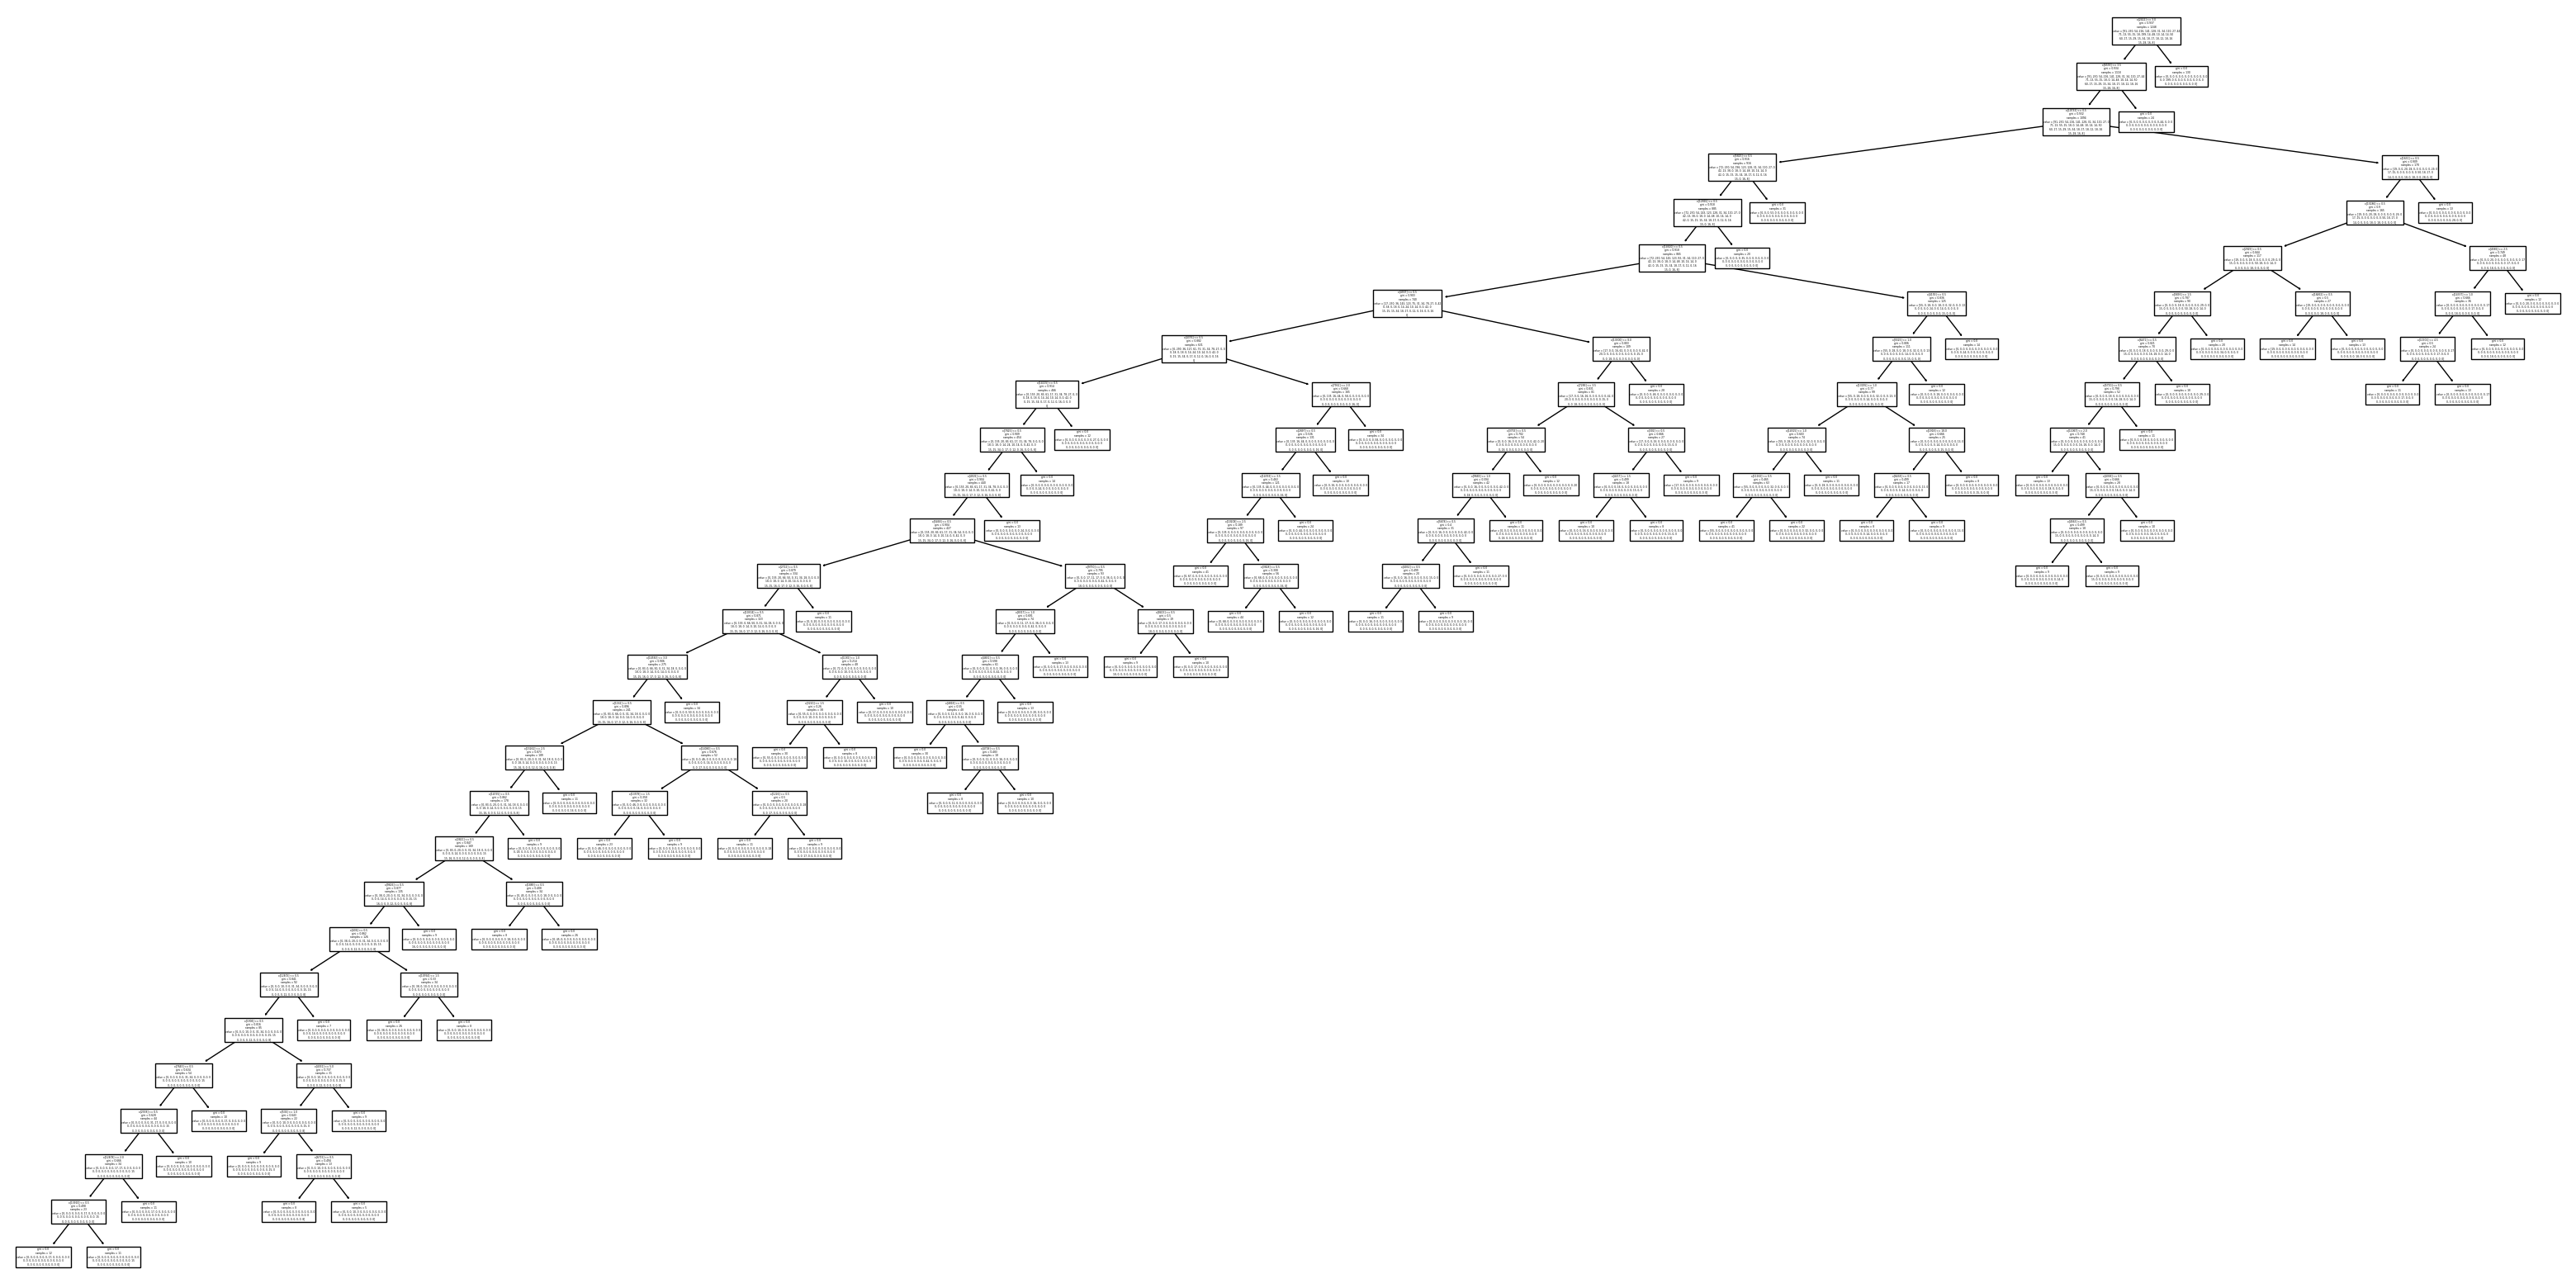

In [74]:
from sklearn.tree import plot_tree
plt.figure(figsize=(40, 20))
plot_tree(model.estimators_[0]);

# Playing with the vectorizer

### Without dealing with imbalance

In [75]:
X= mod_df["text"]
y= mod_df["exp1_industry"]
texts_train, texts_test, Y_train, Y_test = train_test_split(X, y, test_size=0.15,
                                                            random_state=432)

In [76]:
# not using stop words because some profiles are in French and it drastically decreases accuracy 
# I could use the max_df parameter to automatically detect and filter stop words based on intra corpus document frequency of terms.
# using ngram range 1 to 2 increases accuracy - actually returns it to the normal accuracy of balanced dataset
# if we look at the word matrixes, they are actually the same (since resampling = repetition)
vectorizer = CountVectorizer(ngram_range=(1, 2))
vectors = vectorizer.fit_transform(X).todense()

In [77]:
vocabulary = vectorizer.get_feature_names_out()
pd.DataFrame(vectors, columns=vocabulary, index=X).shape

(140, 90796)

In [78]:
X_train = vectorizer.fit_transform(texts_train)
X_test = vectorizer.transform(texts_test)

In [79]:
model_rf = RandomForestClassifier(n_estimators=50, max_depth= 17, random_state= 98)
model_rf.fit(X_train, Y_train)

RandomForestClassifier(max_depth=17, n_estimators=50, random_state=98)

In [80]:
y_pred = model_rf.predict(X_test)
accuracy_score(Y_test, y_pred)

0.6190476190476191

### After dealing with imbalance

In [81]:
train = pd.concat([texts_train, Y_train],axis=1)

unique_ind = train.text.unique()

ind_dict = {elem : pd.DataFrame() for elem in unique_ind}

for key in ind_dict.keys():
    ind_dict[key] = train[:][train.text == key]

for key, value in ind_dict.items():
        if len(value)<=16:
                ind_dict[key] = resample(value, 
                                replace=True,
                                n_samples = 17,
                                random_state=0)

newtrain=ind_dict[list(ind_dict.keys())[0]]
for i in range(1,len(ind_dict.keys())):
    newtrain= pd.concat([newtrain, ind_dict[list(ind_dict.keys())[i]]])

y_train_resampled = newtrain['exp1_industry'].copy()
X_train_resampled = newtrain['text'].copy()

In [82]:
vectorizer = CountVectorizer(ngram_range=(1, 2))
vectors = vectorizer.fit_transform(X).todense()
vocabulary = vectorizer.get_feature_names_out()
pd.DataFrame(vectors, columns=vocabulary, index=X).shape

(140, 90796)

In [83]:
X_train = vectorizer.fit_transform(texts_train)
X_test = vectorizer.transform(texts_test)

In [84]:
model_rf = RandomForestClassifier(n_estimators=50, max_depth= 17, random_state= 98)
model_rf.fit(X_train, Y_train)

RandomForestClassifier(max_depth=17, n_estimators=50, random_state=98)

In [85]:
y_pred = model_rf.predict(X_test)
accuracy_score(Y_test, y_pred)

0.6190476190476191

### Vectorizer with stemming 

In [86]:
X= mod_df["text"]
y= mod_df["exp1_industry"]
texts_train, texts_test, Y_train, Y_test = train_test_split(X, y, test_size=0.15,
                                                            random_state=432)

In [87]:
#stemmer = EnglishStemmer() and stemmer = FrenchStemmer() reduce accuracy
default_analyzer = CountVectorizer().build_analyzer()

In [90]:
stemmer=EnglishStemmer()

In [91]:
def analyze_with_stemming(text):
    unstemmed_words = default_analyzer(text)
    return (stemmer.stem(word) for word in unstemmed_words)

In [92]:
stemmer_vectorizer = CountVectorizer(analyzer=analyze_with_stemming)

vectors = stemmer_vectorizer.fit_transform(X).todense()
vocabulary = stemmer_vectorizer.get_feature_names_out()
pd.DataFrame(vectors, columns=vocabulary, index=X).shape

(140, 17726)

In [93]:
X_train = stemmer_vectorizer.fit_transform(texts_train)
X_test = stemmer_vectorizer.transform(texts_test)
model_rf = RandomForestClassifier(n_estimators=50, max_depth= 17, random_state= 98)
model_rf.fit(X_train, Y_train)

RandomForestClassifier(max_depth=17, n_estimators=50, random_state=98)

In [94]:
y_pred = model_rf.predict(X_test)
accuracy_score(Y_test, y_pred)

0.42857142857142855

# Additional work

In [95]:
# Clean the columns in original dataframe to avoid getting URNs - languages, publications, etc

# Try KNN (cf. Thomas's message)

# remove numbers ? 
# impute industry for the missing ones 
# should some words have more weight than others ? 

# Notes for later : 
# cosine similarity instead of TDIF vectorizer ? 
# use PCA and make clusters of people 
# change the Y to 1/0 based on a civic tech list (e.g. the one that appears when creating companies SQL tables)
# work with companies' data to make clusters of similar companies and predict for that/ recommend closest neighbors (and NGOs)